In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.interpolate import interp1d

In [314]:
# TODO: Fix the interpolation to be more accurate

In [315]:
# === USER SETTINGS ===
csv_filename = 'bon_tableau.csv'  # Replace with the actual file name
colors = {  # Customize stock colors here
    "Nvidia": "green",
    "Tesla": "red",
    "SP500": "yellow",
    "Apple": "black",
    "Amazon": "orange",
}

video_length = 55  # Length of the video in seconds
fps = 30  # FPS for saved video


In [316]:
# === LOAD CSV DATA ===
df = pd.read_csv(csv_filename, sep=';')

# Drop columns with no column name
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Detect stock columns automatically (assumes 'Year' is the only non-stock column)
stock_columns = [col for col in df.columns if col.lower() != 'year']

# Revert the dataframe to its original order
df = df.iloc[::-1].reset_index(drop=True)

# Extract unique years and their positions
unique_years = df["Year"].unique()

# Find and drop rows with NaN values
df = df.dropna()

# Display the first few rows of the dataframe
print(df.head())


   Amazon   Apple  Year
0   97.16   99.99  1999
1   93.80   99.99  1999
2   91.84  103.02  1999
3   96.88  106.05  1999
4   94.64  109.08  1999


In [317]:
# === DATA PROCESSING ===

# Here we ensure that the length of the data can create a video of requested seconds at the given fps

required_length = video_length * fps
current_length = len(df)

initial_data = df.copy()

def adjust_data_length(df, required_length, current_length):

    if current_length < required_length:
        print("Data is not dense enough to create a video of the requested length.")
        print("Interpolating the data to create more points...")

        extra_points = required_length - current_length  # Total extra points needed
        additional_rows = []

        for year in df["Year"].unique():
            df_year = df[df["Year"] == year].copy()
            num_original = len(df_year)
            num_extra = int(extra_points * (num_original / current_length))  # Proportional extra points

            if num_extra > 0 and num_original > 1:
                # Create new indices that include original indices
                original_indices = np.arange(num_original)
                new_indices = np.linspace(0, num_original - 1, num_original + num_extra)

                # Combine original and new indices, ensuring original points are preserved
                combined_indices = np.unique(np.concatenate((original_indices, new_indices)))

                # Create an empty DataFrame for interpolation
                df_interp = pd.DataFrame(index=combined_indices)
                df_interp["Year"] = year

                for stock in stock_columns:
                    # Insert original data
                    df_interp.loc[original_indices, stock] = df_year[stock].values
                    # Interpolate only missing values
                    df_interp[stock] = df_interp[stock].interpolate(method='linear')

                additional_rows.append(df_interp)

        # Combine all years and reset index
        df = pd.concat([df] + additional_rows).sort_values(by=["Year", "Year"]).reset_index(drop=True)



    elif current_length > required_length:
        print("Data is too dense to create a video of the requested length.")
        print("Reducing the number of points to match the requested length...")

        # Compute how many rows we need to drop
        excess_points = current_length - required_length
        reduced_rows = []

        for year in unique_years:
            df_year = df[df["Year"] == year]
            num_original = len(df_year)
            num_remove = int(excess_points * (num_original / current_length))  # Proportionally distribute removal

            if num_remove > 0:
                drop_indices = np.round(np.linspace(0, num_original - 1, num_remove + 2)[1:-1]).astype(int)
                df_reduced = df_year.drop(df_year.index[drop_indices])
                reduced_rows.append(df_reduced)
            else:
                reduced_rows.append(df_year)

        df = pd.concat(reduced_rows).sort_index().reset_index(drop=True)

    return df

df = adjust_data_length(df, required_length, current_length)

year_positions = df.index[df["Year"].diff() != 0]  # Index positions where the year changes


Data is too dense to create a video of the requested length.
Reducing the number of points to match the requested length...


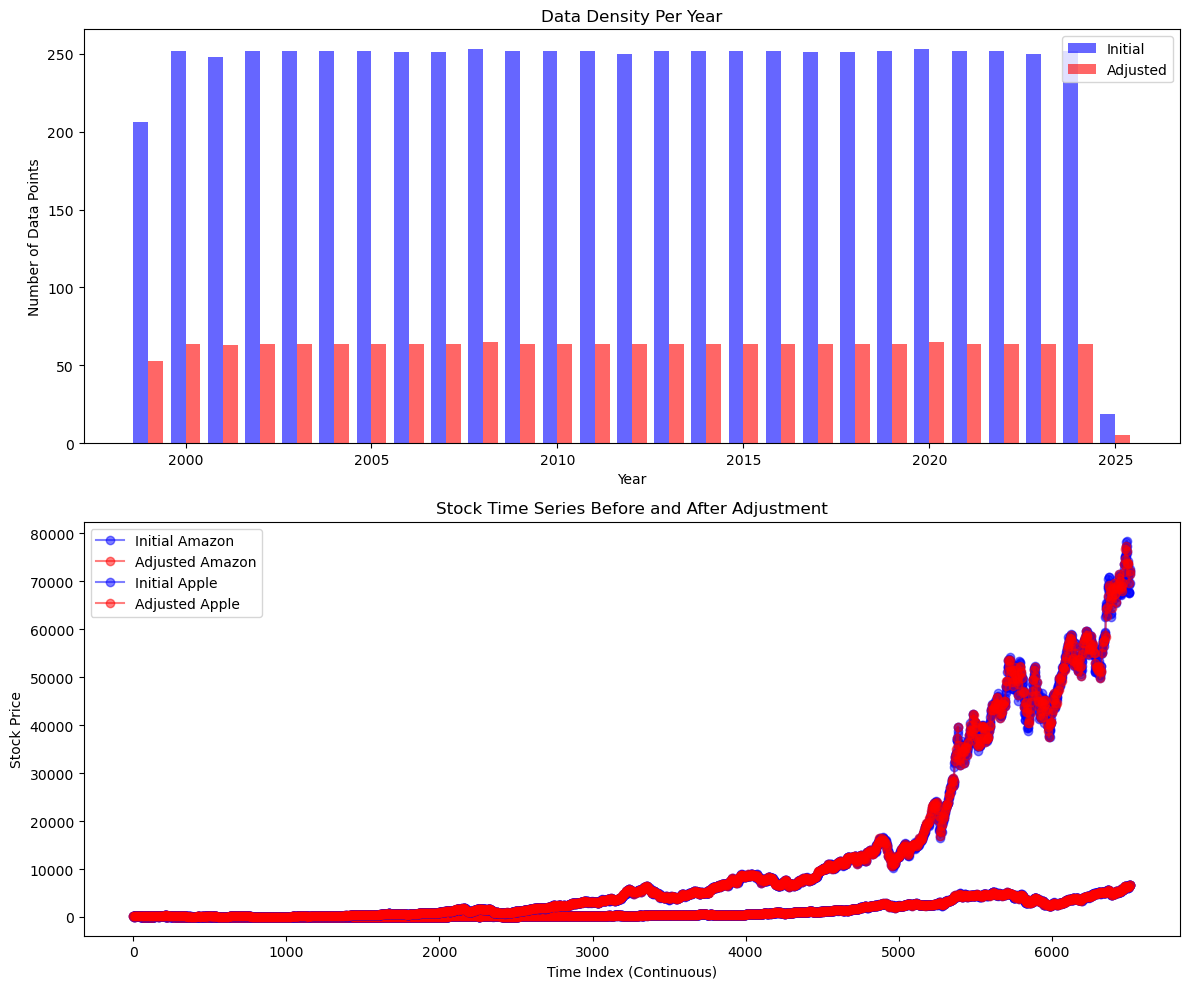

In [318]:
# Create a continuous x-axis variable (cumulative index instead of Year)
initial_data["time_index"] = np.arange(len(initial_data))
df["time_index"] = np.linspace(0, len(initial_data) - 1, len(df))  # Keep proportionate spacing

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Count data points per year before and after adjustment
initial_counts = initial_data["Year"].value_counts().sort_index()
adjusted_counts = df["Year"].value_counts().sort_index()

# Plot number of points per year
axes[0].bar(initial_counts.index - 0.2, initial_counts.values, width=0.4, label="Initial", color="blue", alpha=0.6)
axes[0].bar(adjusted_counts.index + 0.2, adjusted_counts.values, width=0.4, label="Adjusted", color="red", alpha=0.6)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Data Points")
axes[0].set_title("Data Density Per Year")
axes[0].legend()

# Plot stocks using continuous time_index to ensure smooth transitions
for stock in stock_columns:
    axes[1].plot(initial_data["time_index"], initial_data[stock], 'bo-', alpha=0.5, label=f"Initial {stock}")
    axes[1].plot(df["time_index"], df[stock], 'ro-', alpha=0.5, label=f"Adjusted {stock}")

axes[1].set_xlabel("Time Index (Continuous)")
axes[1].set_ylabel("Stock Price")
axes[1].set_title("Stock Time Series Before and After Adjustment")
axes[1].legend()

plt.tight_layout()
plt.show()



Data is too dense to create a video of the requested length.
Reducing the number of points to match the requested length...


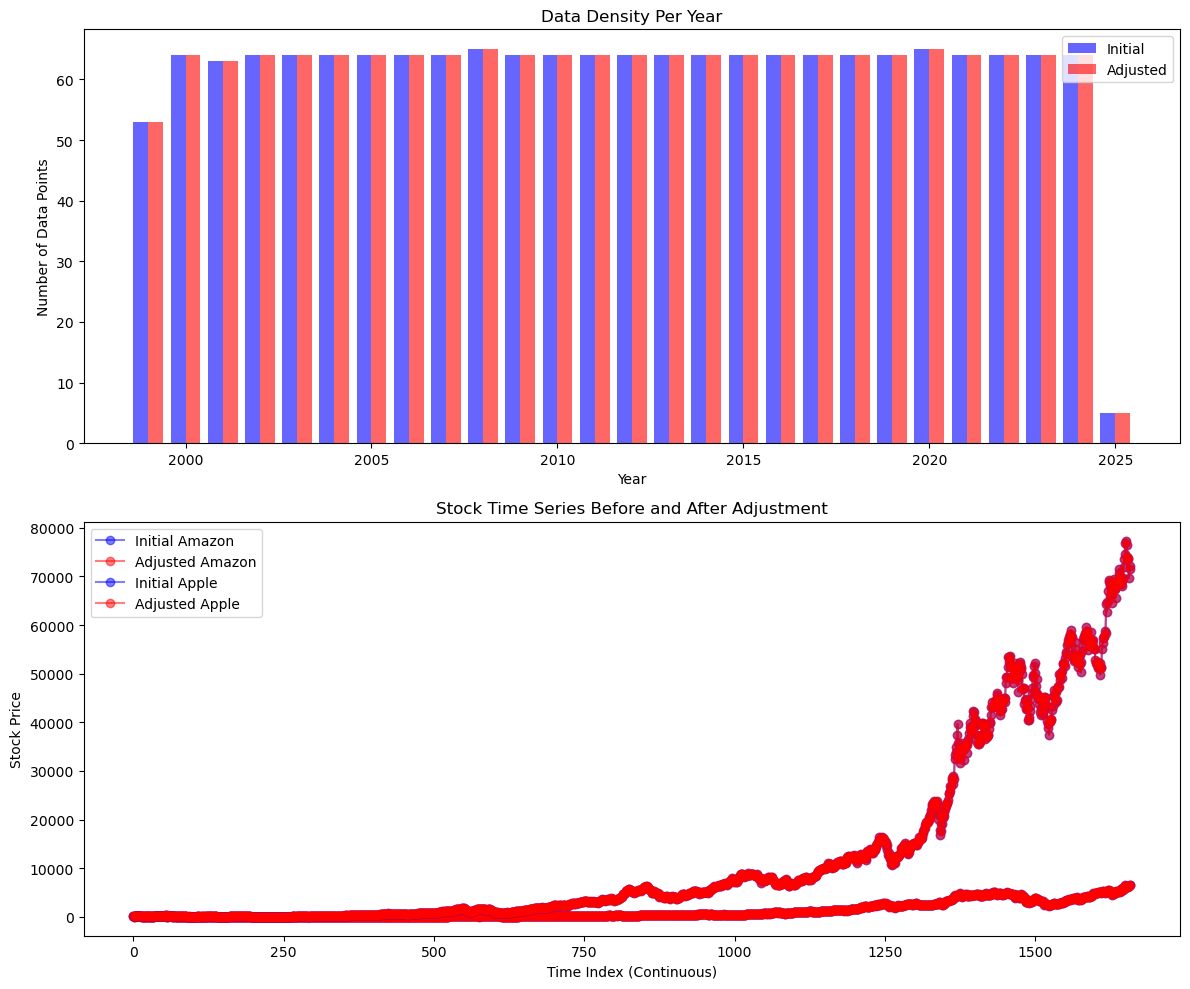

In [319]:
initial_data = df.copy()
current_length = len(df)
df = adjust_data_length(df, required_length, current_length)
# Create a continuous x-axis variable (cumulative index instead of Year)
initial_data["time_index"] = np.arange(len(initial_data))
df["time_index"] = np.linspace(0, len(initial_data) - 1, len(df))  # Keep proportionate spacing

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Count data points per year before and after adjustment
initial_counts = initial_data["Year"].value_counts().sort_index()
adjusted_counts = df["Year"].value_counts().sort_index()

# Plot number of points per year
axes[0].bar(initial_counts.index - 0.2, initial_counts.values, width=0.4, label="Initial", color="blue", alpha=0.6)
axes[0].bar(adjusted_counts.index + 0.2, adjusted_counts.values, width=0.4, label="Adjusted", color="red", alpha=0.6)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Data Points")
axes[0].set_title("Data Density Per Year")
axes[0].legend()

# Plot stocks using continuous time_index to ensure smooth transitions
for stock in stock_columns:
    axes[1].plot(initial_data["time_index"], initial_data[stock], 'bo-', alpha=0.5, label=f"Initial {stock}")
    axes[1].plot(df["time_index"], df[stock], 'ro-', alpha=0.5, label=f"Adjusted {stock}")

axes[1].set_xlabel("Time Index (Continuous)")
axes[1].set_ylabel("Stock Price")
axes[1].set_title("Stock Time Series Before and After Adjustment")
axes[1].legend()

plt.tight_layout()
plt.show()

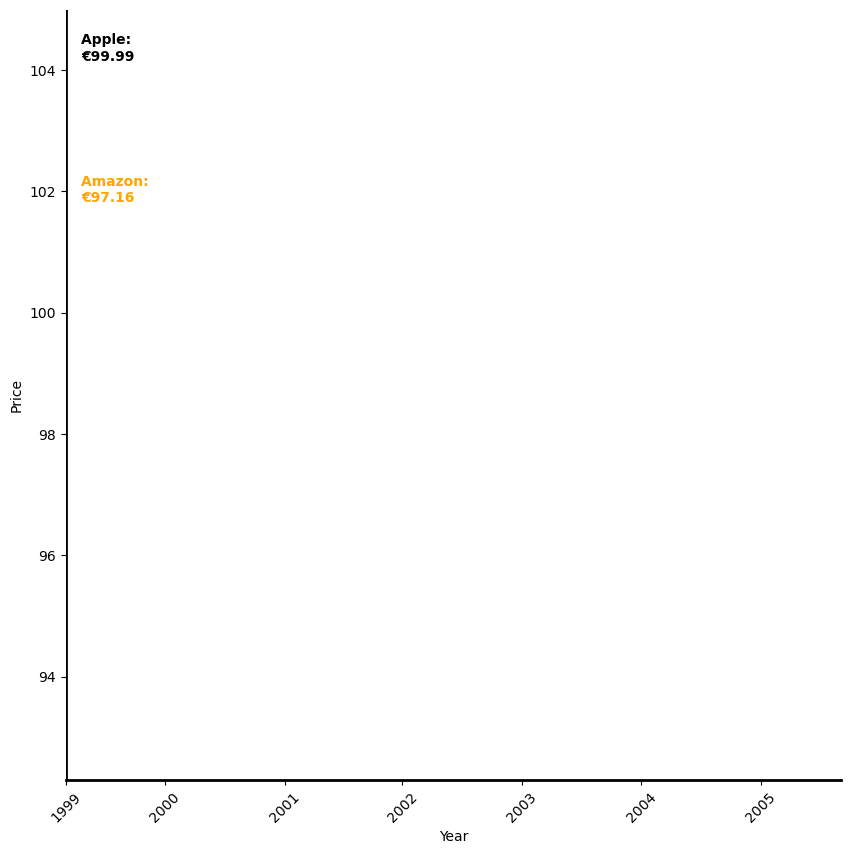

In [ ]:
# === SET UP PLOT ===
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel("Year")
ax.set_ylabel("Price")
# ax.set_title("Stock Performance Over Time")

# Remove all spines (border lines)
for spine in ax.spines.values():
    spine.set_visible(False)



# === INITIALIZE LINES AND TEXT LABELS ===
lines = {stock: ax.plot([], [], label=stock, color=colors.get(stock, "white"), lw=2)[0] for stock in stock_columns}
text_labels = {stock: ax.text(0, 0, "", color=colors.get(stock, "white"), fontsize=12, fontweight='bold') for stock in stock_columns}

# === ANIMATION FUNCTION ===
def animate(i):
    if i >= len(df):
        return
    
    progress = i / len(df) * 100

    ax.clear()
    ax.set_xlabel("Year")
    ax.set_ylabel("Price")
    # ax.set_title("Stock Performance Over Time")

    # Dynamic X-axis scaling (show only the years)
    ax.set_xticks(year_positions)  # Position ticks at year changes
    ax.set_xticklabels(unique_years, rotation=45)  # Display only unique years

    # Increase the x_limit as the progress increases
    x_min = 0
    x_max = i + len(df) * 0.2*(1-progress/100) + len(df) * 0.05

    ax.set_xlim(x_min, x_max)


    # Dynamic Y-axis scaling
    if i == 0:
        ymin = min(df[stock][:1].min() for stock in stock_columns) * 0.95
        ymax = max(df[stock][:1].max() for stock in stock_columns) * 1.05
    else:
        ymin = min(df[stock][:i].min() for stock in stock_columns) * 0.95
        ymax = max(df[stock][:i].max() for stock in stock_columns) * 1.05

    ax.set_ylim(ymin, ymax)

    for stock in stock_columns:
        color = colors.get(stock, "white")

        # Plot line
        ax.plot(df.index[:i], df[stock][:i], label=stock, color=color, lw=3)

        value = df[stock][i]

        # Ensure text stays within bounds of the y-axis
        buffer_y = (ymax - ymin) * 0.05  # 5% buffer to avoid text getting cut off
        text_y_pos = max(min(df[stock][i] * 1.05, ymax - buffer_y), ymin + buffer_y)

        # Ensure text stays within bounds of the x-axis
        buffer_x = (x_max - x_min) * 0.02  # 2% buffer to avoid text going out
        text_x_pos = max(min(df.index[i] + (x_max - x_min) * 0.01, x_max - buffer_x), x_min + buffer_x)

        # Update labels dynamically
        ax.text(text_x_pos, text_y_pos, f"{stock}: \n€ {value:.2f}", color=color, fontsize=10, fontweight='bold', va='center', ha='left', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))
    
    # Keep only the x and y axes
    ax.axhline(y=ymin, color="black", linewidth=2, clip_on=False)
    ax.axvline(x=0, color="black", linewidth=2)

# === CREATE ANIMATION ===
ani = animation.FuncAnimation(fig, animate, frames=len(df) + 50, interval=1000/fps)

# === SAVE ANIMATION ===
mp4_filename = 'stock_animation.mp4'
ani.save(mp4_filename, writer='ffmpeg', fps=fps)

